In [76]:
import arviz as az
import pandas as pd
import numpy as np
import constants as c
import os
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax

from jax import random
from numpyro.infer import MCMC, NUTS

_ = jnp.ones((3,))
jax.devices()



[gpu(id=0)]

In [88]:
df = pd.read_parquet(os.path.join(c.DATA_DIR, 'brvehins', 'brvehins_clean.parquet'))
df['log_exposure'] = np.log10(df['ExposTotal'])

n_cities = df['city_idx'].max() + 1

# Our other factors are VehCategory and VehBrand; these will be used as categorical variables
# to index into random effects for each category and brand
n_categories = df['VehCategory'].cat.codes.max() + 1
n_brands = df['VehBrand'].cat.codes.max() + 1

city_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'br_city_lat_long.parquet')
city_df = pd.read_parquet(city_filepath)


In [78]:
def model(city_idx, brand_idx, category_idx, log_exposure, claim_nb_coll, times):

    # Hyperparameters for the city random effect
    mu_city = numpyro.sample('mu_city', dist.Normal(0, 1))
    sigma_city = numpyro.sample('sigma_city', dist.HalfCauchy(1))

    # Random effect for each city
    with numpyro.plate('city', n_cities):
        city_effect = numpyro.sample('city_effect', dist.Normal(mu_city, sigma_city))

    mu_brand = numpyro.sample('mu_brand', dist.Normal(0, 1))
    sigma_brand = numpyro.sample('sigma_brand', dist.HalfCauchy(1))

    # random effect for each brand
    with numpyro.plate('brand', n_brands):
        brand_effect = numpyro.sample('brand_effect', dist.Normal(mu_brand, sigma_brand))

    mu_category = numpyro.sample('mu_category', dist.Normal(0, 1))
    sigma_category = numpyro.sample('sigma_category', dist.HalfCauchy(1))

    # random effect for each category
    with numpyro.plate('category', n_categories):
        category_effect = numpyro.sample('category_effect', dist.Normal(mu_category, sigma_category))

    # Gaussian random walk effect for time
    n_timesteps = len(np.unique(times))
    sigma_grw = numpyro.sample('sigma_grw', dist.HalfCauchy(1))
    grw = numpyro.sample('grw', dist.GaussianRandomWalk(scale=sigma_grw, num_steps=n_timesteps))
    
    # Global offset with single free parameter to be added to log mean
    log_offset = numpyro.sample('log_offset', dist.Normal(0, 1))

    # Model for the log-mean
    log_mean = log_exposure + city_effect[city_idx] + brand_effect[brand_idx] + category_effect[category_idx] + grw[times] + log_offset

    mu = jnp.exp(log_mean)

    # Poisson likelihood
    with numpyro.plate('data', len(city_idx)):
        numpyro.sample('obs', dist.Poisson(mu), obs=claim_nb_coll)
        
# Run NUTS
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=500, num_chains=1, thinning=50)

# Clocks at 12s/it at 1024 steps on CPU, so ~10 ms per stepb
mcmc.run(rng_key_, 
            city_idx=df['city_idx'].values,
            brand_idx=df['VehBrand'].cat.codes.values,
            category_idx=df['VehCategory'].cat.codes.values,
            log_exposure=df['log_exposure'].values,
            claim_nb_coll=df['ClaimNbColl'].values,
            times=df['VehYearSince1971'].values)


sample: 100%|██████████| 1000/1000 [1:23:14<00:00,  4.99s/it, 1023 steps of size 1.85e-03. acc. prob=0.93]


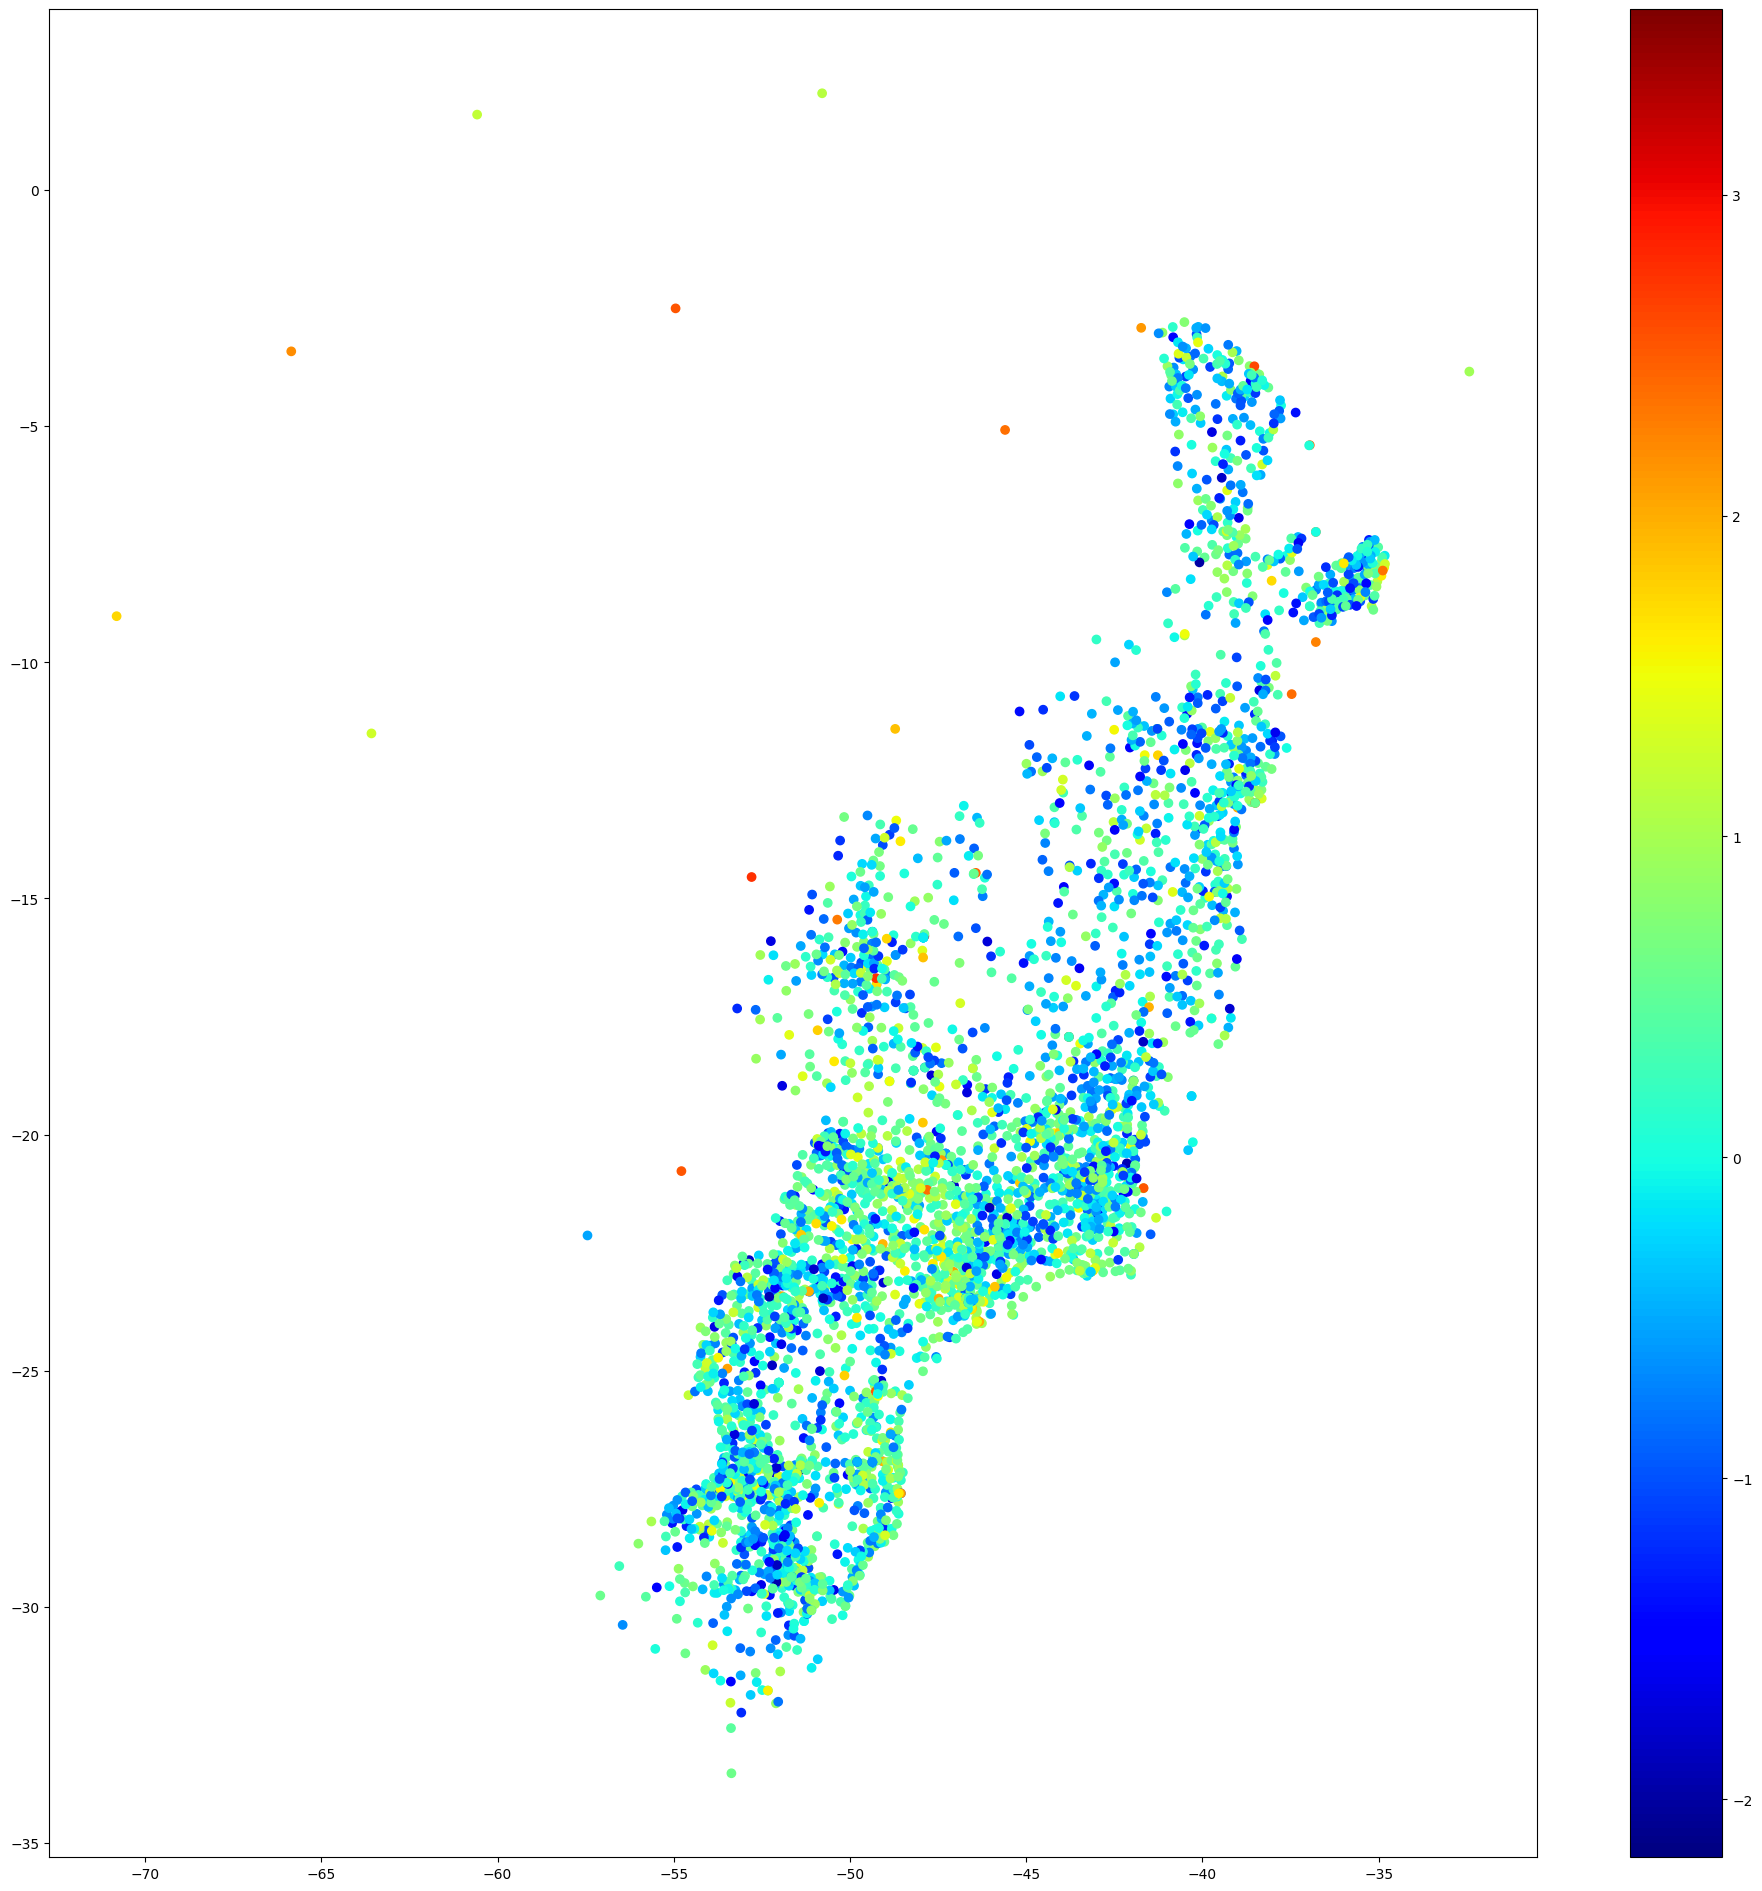

In [100]:
plt.figure(figsize=(24,24))
plt.scatter(city_df.long, city_df.lat, c=city_effect, cmap='jet')
plt.colorbar()

In [79]:
trace = az.from_numpyro(mcmc)

city_effect     = trace.posterior.city_effect.mean(axis=(0,1)).values
brand_effect    = trace.posterior.brand_effect.mean(axis=(0,1)).values
category_effect = trace.posterior.category_effect.mean(axis=(0,1)).values
grw             = trace.posterior.grw.mean(axis=(0,1)).values
log_offset      = trace.posterior.log_offset.mean(axis=(0,1)).values


log_mu = log_exposure=df['log_exposure'].values + city_effect[df['city_idx'].values] + log_offset + \
    brand_effect[df['VehBrand'].cat.codes.values] + category_effect[df['VehCategory'].cat.codes.values] + \
    grw[df['VehYearSince1971'].values] 

   
mu = np.exp(log_mu)

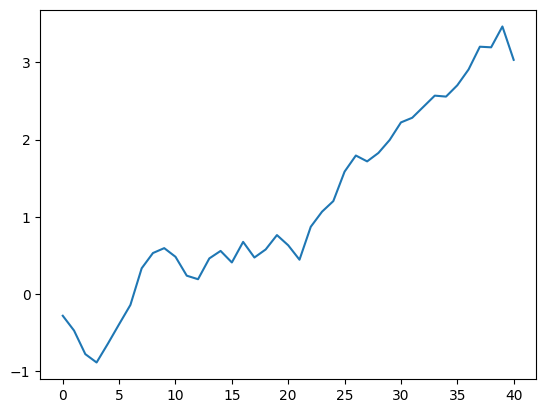

In [84]:

plt.plot(grw)

(-2.0, 15.0)

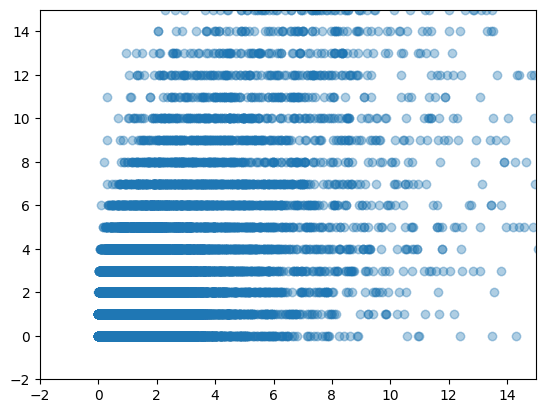

In [86]:
plt.scatter(mu, df['ClaimNbColl'].values, alpha=0.1)
plt.ylim(-2,15)
plt.xlim(-2,15)


In [29]:
df['city_idx'].max()

3802